# COVID-19 Data Exploration & Visualization

In this project, we will explore a collection of COVID-19 data maintained by [Our World in Data](https://ourworldindata.org). This data contains daily confirmed cases, deaths, and testing. The date range for this dataset is from 1-1-2020 through 10-14-2021. An updated version of the data is [available for download](https://ourworldindata.org/covid-deaths). This copy of the dataset was downloaded on 10-15-2021.

In [53]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import altair as alt

pd.options.mode.chained_assignment = None
covid_full = pd.read_csv('owid-covid-data.csv', parse_dates=['date']) #This parses the date column as a datetime object

In [2]:
covid_full.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [3]:
covid_full.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
123750,ZWE,Africa,Zimbabwe,2021-10-12,132016.0,141.0,115.857,4645.0,2.0,2.571,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
123751,ZWE,Africa,Zimbabwe,2021-10-13,132108.0,92.0,96.286,4648.0,3.0,2.571,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
123752,ZWE,Africa,Zimbabwe,2021-10-14,132251.0,143.0,104.000,4655.0,7.0,3.429,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


In [4]:
covid_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123753 entries, 0 to 123752
Data columns (total 65 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   iso_code                                 123753 non-null  object        
 1   continent                                118139 non-null  object        
 2   location                                 123753 non-null  object        
 3   date                                     123753 non-null  datetime64[ns]
 4   total_cases                              117134 non-null  float64       
 5   new_cases                                117130 non-null  float64       
 6   new_cases_smoothed                       116116 non-null  float64       
 7   total_deaths                             106268 non-null  float64       
 8   new_deaths                               106421 non-null  float64       
 9   new_deaths_smoothed       

# Initial observations
In this fairly large dataset, there are some columns that seem more useful for analysis:
* total_cases
* new_cases
* total_deaths
* new_deaths
* new_vaccinations
* total_vaccinations
* people_vaccinated
* population

Much of the other data has potential for analysis, but for this project, we will focus on the columns listed above. As such, let's create a new dataframe containing only the data in which we're interested.

In [5]:
covid_select = covid_full[["continent", "location", "date", "total_cases", "new_cases", "total_deaths", "new_deaths", "new_vaccinations", "total_vaccinations", "people_vaccinated", "population"]]
covid_select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123753 entries, 0 to 123752
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   continent           118139 non-null  object        
 1   location            123753 non-null  object        
 2   date                123753 non-null  datetime64[ns]
 3   total_cases         117134 non-null  float64       
 4   new_cases           117130 non-null  float64       
 5   total_deaths        106268 non-null  float64       
 6   new_deaths          106421 non-null  float64       
 7   new_vaccinations    24130 non-null   float64       
 8   total_vaccinations  29101 non-null   float64       
 9   people_vaccinated   27661 non-null   float64       
 10  population          122881 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 10.4+ MB


# Percent infected, dead, and vaccinated

It would be valuable to know how the percentage of people infected, dead, or vaccinated change over time. Therefore, we will add these values to our dataframe as new columns. We'll calculate this now and then visualize it a little later.

In [6]:
# add percent_dead to covid_select
covid_select['percent_dead'] = (covid_select['total_deaths'] / covid_select['total_cases']) * 100
covid_select[['location', 'date', 'percent_dead']]

,location,date,percent_dead
0,Afghanistan,2020-02-24,NaN
1,Afghanistan,2020-02-25,NaN
2,Afghanistan,2020-02-26,NaN
3,Afghanistan,2020-02-27,NaN
4,Afghanistan,2020-02-28,NaN
...,...,...,...
123748,Zimbabwe,2021-10-10,3.518316
123749,Zimbabwe,2021-10-11,3.520758
123750,Zimbabwe,2021-10-12,3.518513
123751,Zimbabwe,2021-10-13,3.518333


In [7]:
# add percent_infected to covid_select
covid_select['percent_infected'] = (covid_select['total_cases'] / covid_select['population']) * 100
covid_select[['location', 'date', 'percent_infected']]

,location,date,percent_infected
0,Afghanistan,2020-02-24,0.000013
1,Afghanistan,2020-02-25,0.000013
2,Afghanistan,2020-02-26,0.000013
3,Afghanistan,2020-02-27,0.000013
4,Afghanistan,2020-02-28,0.000013
...,...,...,...
123748,Zimbabwe,2021-10-10,0.873274
123749,Zimbabwe,2021-10-11,0.873797
123750,Zimbabwe,2021-10-12,0.874732
123751,Zimbabwe,2021-10-13,0.875341


In [8]:
# add percent_vaxed to covid_select
covid_select['percent_vaxed'] = (covid_select['people_vaccinated'] / covid_select['population']) * 100
covid_select[['location', 'date', 'percent_vaxed']]

,location,date,percent_vaxed
0,Afghanistan,2020-02-24,NaN
1,Afghanistan,2020-02-25,NaN
2,Afghanistan,2020-02-26,NaN
3,Afghanistan,2020-02-27,NaN
4,Afghanistan,2020-02-28,NaN
...,...,...,...
123748,Zimbabwe,2021-10-10,21.013537
123749,Zimbabwe,2021-10-11,21.046972
123750,Zimbabwe,2021-10-12,21.090504
123751,Zimbabwe,2021-10-13,21.143260


## Add month/year column

We would like to get the big picture for our data. For example, it will be helpful to see how many people are infected, dead, or vaccinated in each month. For the purpose of aggregation, it will be useful to group each row according to its month and year. Therefore, we will add a new column called `month_year` and assign it to the first of that month.

In [9]:
# Create new column for month and year data to be used for aggregation
covid_select['month_year'] = covid_select['date'].dt.strftime('%Y-%m')
covid_select['month_year'].value_counts()

2021-07    7130
2021-08    7109
2021-05    6975
2021-06    6846
2021-09    6764
2021-03    6760
2021-04    6674
2021-01    6322
2020-12    6175
2020-10    6069
2020-08    6045
2020-07    6045
2020-05    6033
2021-02    6022
2020-11    5944
2020-09    5850
2020-06    5850
2020-04    5743
2020-03    4555
2021-10    3052
2020-02    1446
2020-01     344
Name: month_year, dtype: int64

In [10]:
covid_select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123753 entries, 0 to 123752
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   continent           118139 non-null  object        
 1   location            123753 non-null  object        
 2   date                123753 non-null  datetime64[ns]
 3   total_cases         117134 non-null  float64       
 4   new_cases           117130 non-null  float64       
 5   total_deaths        106268 non-null  float64       
 6   new_deaths          106421 non-null  float64       
 7   new_vaccinations    24130 non-null   float64       
 8   total_vaccinations  29101 non-null   float64       
 9   people_vaccinated   27661 non-null   float64       
 10  population          122881 non-null  float64       
 11  percent_dead        106267 non-null  float64       
 12  percent_infected    116518 non-null  float64       
 13  percent_vaxed       27644 non

## Countries, Continents, and World

Our data includes columns for `continent` and `location`. There are, however, 5,614 rows with no continent data.

In [11]:
covid_select['continent'].value_counts(dropna=False)

Africa           31297
Europe           28936
Asia             28903
North America    15939
South America     7244
Oceania           5820
NaN               5614
Name: continent, dtype: int64

In [12]:
covid_select[covid_select['continent'].isna()]

,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,new_vaccinations,total_vaccinations,people_vaccinated,population,percent_dead,percent_infected,percent_vaxed,month_year
599,NaN,Africa,2020-02-13,NaN,0.0,NaN,0.0,NaN,NaN,NaN,1.373486e+09,NaN,NaN,NaN,2020-02
600,NaN,Africa,2020-02-14,1.0,1.0,NaN,0.0,NaN,NaN,NaN,1.373486e+09,NaN,7.280742e-08,NaN,2020-02
601,NaN,Africa,2020-02-15,1.0,0.0,NaN,0.0,NaN,NaN,NaN,1.373486e+09,NaN,7.280742e-08,NaN,2020-02
602,NaN,Africa,2020-02-16,1.0,0.0,NaN,0.0,NaN,NaN,NaN,1.373486e+09,NaN,7.280742e-08,NaN,2020-02
603,NaN,Africa,2020-02-17,1.0,0.0,NaN,0.0,NaN,NaN,NaN,1.373486e+09,NaN,7.280742e-08,NaN,2020-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122045,NaN,World,2021-10-10,237879268.0,300669.0,4851586.0,4480.0,28535451.0,6.537657e+09,3.695414e+09,7.874966e+09,2.039516,3.020702e+00,46.926090,2021-10
122046,NaN,World,2021-10-11,238272643.0,393375.0,4857420.0,5834.0,17938575.0,6.555596e+09,3.702378e+09,7.874966e+09,2.038597,3.025698e+00,47.014534,2021-10
122047,NaN,World,2021-10-12,238705193.0,432550.0,4865619.0,8199.0,23551260.0,6.579147e+09,3.712051e+09,7.874966e+09,2.038338,3.031190e+00,47.137365,2021-10
122048,NaN,World,2021-10-13,239167859.0,462666.0,4874258.0,8639.0,19222594.0,6.598370e+09,3.720156e+09,7.874966e+09,2.038007,3.037065e+00,47.240280,2021-10


In those cases, the location *is* the continent. That means that these rows duplicate the data from other rows. For example, the North America rows combine the data from Canada, Mexico, and USA. In fact, there are some rows that represent the entire world. Therefore, we will split our data into three dataframes: 

1. country-level data  
2. continent-level data
3. world-level data

In [13]:
# get rows that belong to countries
covid_countries = covid_select[~covid_select['continent'].isna()]
covid_countries

,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,new_vaccinations,total_vaccinations,people_vaccinated,population,percent_dead,percent_infected,percent_vaxed,month_year
0,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,NaN,39835428.0,NaN,0.000013,NaN,2020-02
1,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,NaN,39835428.0,NaN,0.000013,NaN,2020-02
2,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,NaN,39835428.0,NaN,0.000013,NaN,2020-02
3,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,NaN,39835428.0,NaN,0.000013,NaN,2020-02
4,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,NaN,39835428.0,NaN,0.000013,NaN,2020-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123748,Africa,Zimbabwe,2021-10-10,131796.0,34.0,4637.0,1.0,9206.0,5581524.0,3171399.0,15092171.0,3.518316,0.873274,21.013537,2021-10
123749,Africa,Zimbabwe,2021-10-11,131875.0,79.0,4643.0,6.0,13284.0,5594808.0,3176445.0,15092171.0,3.520758,0.873797,21.046972,2021-10
123750,Africa,Zimbabwe,2021-10-12,132016.0,141.0,4645.0,2.0,17668.0,5612476.0,3183015.0,15092171.0,3.518513,0.874732,21.090504,2021-10
123751,Africa,Zimbabwe,2021-10-13,132108.0,92.0,4648.0,3.0,20058.0,5632534.0,3190977.0,15092171.0,3.518333,0.875341,21.143260,2021-10


In [14]:
covid_countries['continent'].value_counts(dropna=False)

Africa           31297
Europe           28936
Asia             28903
North America    15939
South America     7244
Oceania           5820
Name: continent, dtype: int64

In [15]:
# get rows that belong to continents
covid_continents = covid_select[covid_select['continent'].isna()]
covid_continents

,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,new_vaccinations,total_vaccinations,people_vaccinated,population,percent_dead,percent_infected,percent_vaxed,month_year
599,NaN,Africa,2020-02-13,NaN,0.0,NaN,0.0,NaN,NaN,NaN,1.373486e+09,NaN,NaN,NaN,2020-02
600,NaN,Africa,2020-02-14,1.0,1.0,NaN,0.0,NaN,NaN,NaN,1.373486e+09,NaN,7.280742e-08,NaN,2020-02
601,NaN,Africa,2020-02-15,1.0,0.0,NaN,0.0,NaN,NaN,NaN,1.373486e+09,NaN,7.280742e-08,NaN,2020-02
602,NaN,Africa,2020-02-16,1.0,0.0,NaN,0.0,NaN,NaN,NaN,1.373486e+09,NaN,7.280742e-08,NaN,2020-02
603,NaN,Africa,2020-02-17,1.0,0.0,NaN,0.0,NaN,NaN,NaN,1.373486e+09,NaN,7.280742e-08,NaN,2020-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122045,NaN,World,2021-10-10,237879268.0,300669.0,4851586.0,4480.0,28535451.0,6.537657e+09,3.695414e+09,7.874966e+09,2.039516,3.020702e+00,46.926090,2021-10
122046,NaN,World,2021-10-11,238272643.0,393375.0,4857420.0,5834.0,17938575.0,6.555596e+09,3.702378e+09,7.874966e+09,2.038597,3.025698e+00,47.014534,2021-10
122047,NaN,World,2021-10-12,238705193.0,432550.0,4865619.0,8199.0,23551260.0,6.579147e+09,3.712051e+09,7.874966e+09,2.038338,3.031190e+00,47.137365,2021-10
122048,NaN,World,2021-10-13,239167859.0,462666.0,4874258.0,8639.0,19222594.0,6.598370e+09,3.720156e+09,7.874966e+09,2.038007,3.037065e+00,47.240280,2021-10


There are rows in our `covid_continents` dataset where the location value is `World`. This is clearly meant to be a summary of all the data. As such, we will import it into a new dataframe called `covid_world`.

In [16]:
# get rows that belong to "world" location
covid_world = covid_select[covid_select['location'] == 'World']
covid_world

,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,new_vaccinations,total_vaccinations,people_vaccinated,population,percent_dead,percent_infected,percent_vaxed,month_year
121418,NaN,World,2020-01-22,557.0,0.0,17.0,0.0,NaN,NaN,NaN,7.874966e+09,3.052065,0.000007,NaN,2020-01
121419,NaN,World,2020-01-23,655.0,98.0,18.0,1.0,NaN,NaN,NaN,7.874966e+09,2.748092,0.000008,NaN,2020-01
121420,NaN,World,2020-01-24,941.0,286.0,26.0,8.0,NaN,NaN,NaN,7.874966e+09,2.763018,0.000012,NaN,2020-01
121421,NaN,World,2020-01-25,1434.0,493.0,42.0,16.0,NaN,NaN,NaN,7.874966e+09,2.928870,0.000018,NaN,2020-01
121422,NaN,World,2020-01-26,2118.0,684.0,56.0,14.0,NaN,NaN,NaN,7.874966e+09,2.644004,0.000027,NaN,2020-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122045,NaN,World,2021-10-10,237879268.0,300669.0,4851586.0,4480.0,28535451.0,6.537657e+09,3.695414e+09,7.874966e+09,2.039516,3.020702,46.926090,2021-10
122046,NaN,World,2021-10-11,238272643.0,393375.0,4857420.0,5834.0,17938575.0,6.555596e+09,3.702378e+09,7.874966e+09,2.038597,3.025698,47.014534,2021-10
122047,NaN,World,2021-10-12,238705193.0,432550.0,4865619.0,8199.0,23551260.0,6.579147e+09,3.712051e+09,7.874966e+09,2.038338,3.031190,47.137365,2021-10
122048,NaN,World,2021-10-13,239167859.0,462666.0,4874258.0,8639.0,19222594.0,6.598370e+09,3.720156e+09,7.874966e+09,2.038007,3.037065,47.240280,2021-10


Since we have a `covid_world` dataframe with world data, we will remove world data from the `covid_continents` dataframe.

In [17]:
# Drop rows where the location is 'World'
covid_continents = covid_continents[covid_continents.location != 'World']

# Verify that World rows have been dropped
covid_continents['location'].value_counts()

Asia              632
North America     632
Europe            631
European Union    631
Oceania           629
International     616
Africa            610
South America     601
Name: location, dtype: int64

Similarly, we have some duplicated data as a result of having both `Europe` and `European Union` as location values. As such, we will remove `European Union` from our continents dataframe.

In [18]:
# Drop rows where the location is 'European Union'
covid_continents = covid_continents[covid_continents.location != 'European Union']

# Verify that World rows have been dropped
covid_continents['location'].value_counts()

Asia             632
North America    632
Europe           631
Oceania          629
International    616
Africa           610
South America    601
Name: location, dtype: int64

# Countries with highest rates of infection and death

Next, let's find out where the highest rates of infection and death due to COVID-19 are located in our `covid_countries` dataset. To accomplish this, we will create a new dataframe called `countries_rates` where each row represents one location from our original dataset. Here, we are not interested in how the data changes over time. Instead, we want to see how each country has fared with COVID-19 overall. To do this, we will compare their population to the maximum number of deaths and cases.

In [19]:
# Create a list of unique locations (countries) in our dataset
locations = covid_countries['location'].unique()

In [20]:
# Create a new dataframe
countries_rates = pd.DataFrame(columns = ['location', 'percent_infected', 'percent_dead', 'percent_vaxed'])

In [21]:
# Iterate through the locations and collect data
for l in locations:
    selected_rows = covid_countries[covid_countries['location'] == l]
    max_total_cases = selected_rows['total_cases'].max()
    max_total_deaths = selected_rows['total_deaths'].max()
    max_total_vaxed = selected_rows['people_vaccinated'].max()
    pop = selected_rows['population'].max()
    
    infection_rate = (max_total_cases / pop) * 100
    death_rate = (max_total_deaths / pop) * 100
    vax_rate = (max_total_vaxed / pop) * 100
    
    # add data to new dataframe
    countries_rates = countries_rates.append({'location' : l, 'percent_infected' : infection_rate, 'percent_dead' : death_rate, 'percent_vaxed' : vax_rate }, ignore_index=True)

## Highest infection rates - Top 15 countries
Using our new `countries_rates` dataframe, we can sort by `percent_infected` in order to get a ranking of the countries by infection rate when compared to the population.

In [22]:
# Sort values by highest_infection_rate
countries_rates.sort_values(by=['percent_infected'], inplace=True, ascending=False)

We will create a new dataframe, `top15`, that holds the countries with the highest infection rates.

In [23]:
top15 = countries_rates.head(15)
top15

,location,percent_infected,percent_dead,percent_vaxed
177,Seychelles,22.094834,0.119300,78.162976
133,Montenegro,21.762723,0.320038,40.089419
3,Andorra,19.812809,0.168059,70.212271
74,Georgia,16.317689,0.235441,25.316218
172,San Marino,16.083505,0.267568,73.146133
52,Czechia,15.903059,0.284618,57.078062
122,Maldives,15.807365,0.043597,72.356425
14,Bahrain,15.781776,0.079563,66.933784
97,Israel,14.936763,0.090696,70.531081
176,Serbia,14.928338,0.129498,44.363501


To get a better feeling for this data, we will turn it into a bar chart using `matplotlib`.

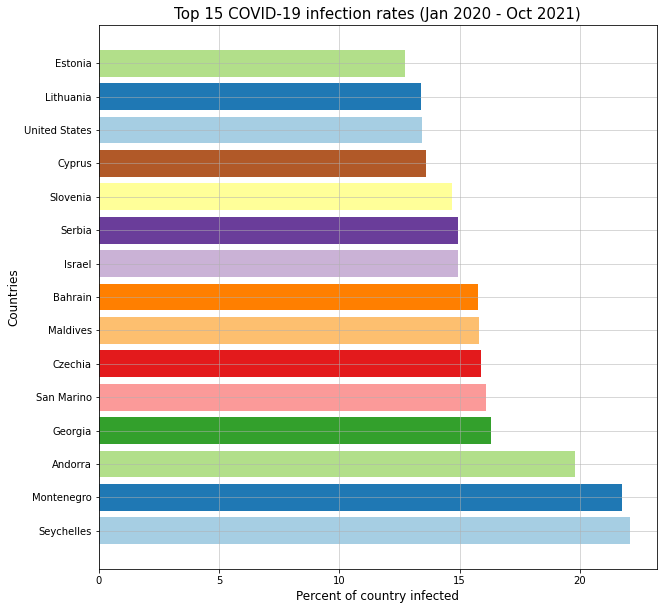

In [24]:
# Create a bar chart
col_map = plt.get_cmap('Paired')

# Set default figure size
plt.rcParams["figure.figsize"] = (10, 10)

plt.barh(top15.location, top15.percent_infected, label='Infections', color=col_map.colors)
plt.title('Top 15 COVID-19 infection rates (Jan 2020 - Oct 2021)', fontsize=15)
plt.grid(linewidth=0.5)
plt.ylabel('Countries', fontsize=12)
plt.xlabel('Percent of country infected', fontsize=12)
plt.show()

## Highest death rates - Top 15 countries
If we resort our `top15` dataset __ FIXME

In [25]:
# Sort values by highest_death_rate
top15.sort_values(by=['percent_infected'], inplace=True, ascending=False)

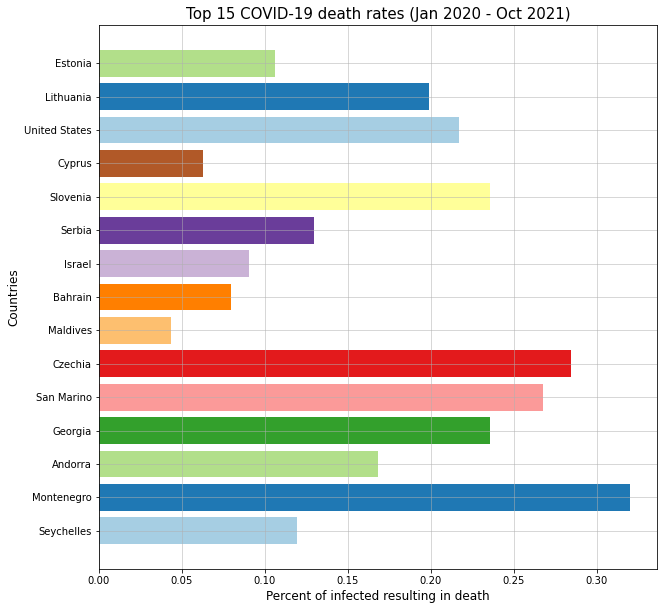

In [26]:
# Create a bar chart
plt.barh(top15.location, top15.percent_dead, label='Dead', color=col_map.colors)
# plt.bar(top15_countries_infection.location+wd, top15_countries_infection.highest_infection_rate, 
        #color='r', width=wd, label='Deaths')

plt.title('Top 15 COVID-19 death rates (Jan 2020 - Oct 2021)', fontsize=15)
plt.grid(linewidth=0.5)
plt.ylabel('Countries', fontsize=12)
plt.xlabel('Percent of infected resulting in death', fontsize=12)
plt.show()

# Infections by continent
Next, we will take a look at our dataset from the continent-level. Using a pandas groupby function, we are able to track infections by continent over time.

In [27]:
continents_infections_monthly = covid_continents.groupby(['month_year', 'location'])['total_cases'].aggregate('max').unstack()
continents_infections_monthly.head()

location,Africa,Asia,Europe,International,North America,Oceania,South America
month_year,,,,,,,
2020-01,NaN,9889.0,17.0,NaN,12.0,9.0,NaN
2020-02,3.0,83728.0,1506.0,705.0,50.0,26.0,4.0
2020-03,5779.0,179024.0,465213.0,714.0,205818.0,5212.0,14496.0
2020-04,38753.0,520649.0,1357788.0,721.0,1175287.0,8271.0,180235.0
2020-05,146551.0,1138627.0,1959828.0,721.0,2032863.0,8732.0,901684.0


In [28]:
continents_infections_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 2020-01 to 2021-10
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Africa         21 non-null     float64
 1   Asia           22 non-null     float64
 2   Europe         22 non-null     float64
 3   International  21 non-null     float64
 4   North America  22 non-null     float64
 5   Oceania        22 non-null     float64
 6   South America  21 non-null     float64
dtypes: float64(7)
memory usage: 1.4+ KB


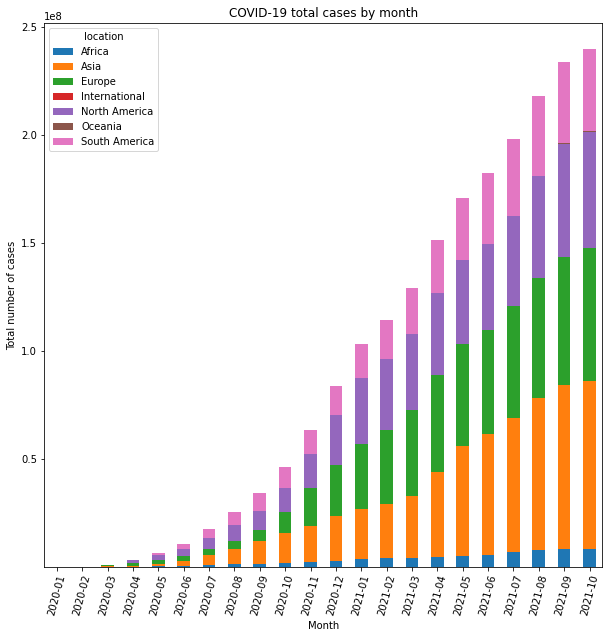

In [29]:
continents_infections_monthly.plot.bar(stacked=True, rot=75, title="COVID-19 total cases by month")
plt.xlabel('Month')
plt.ylabel('Total number of cases')
plt.show(block=True)

# Deaths by continent

In [30]:
continents_deaths_monthly = covid_continents.groupby(['month_year', 'location'])['total_deaths'].aggregate('max').unstack()
continents_deaths_monthly.head()

location,Africa,Asia,Europe,International,North America,Oceania,South America
month_year,,,,,,,
2020-01,NaN,213.0,NaN,NaN,NaN,NaN,NaN
2020-02,NaN,2904.0,32.0,6.0,1.0,NaN,NaN
2020-03,200.0,7141.0,31184.0,10.0,5646.0,19.0,484.0
2020-04,1634.0,18703.0,135098.0,15.0,72926.0,112.0,12541.0
2020-05,4222.0,30828.0,172559.0,15.0,126976.0,125.0,56287.0


In [31]:
continents_deaths_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 2020-01 to 2021-10
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Africa         20 non-null     float64
 1   Asia           22 non-null     float64
 2   Europe         21 non-null     float64
 3   International  21 non-null     float64
 4   North America  21 non-null     float64
 5   Oceania        20 non-null     float64
 6   South America  20 non-null     float64
dtypes: float64(7)
memory usage: 1.4+ KB


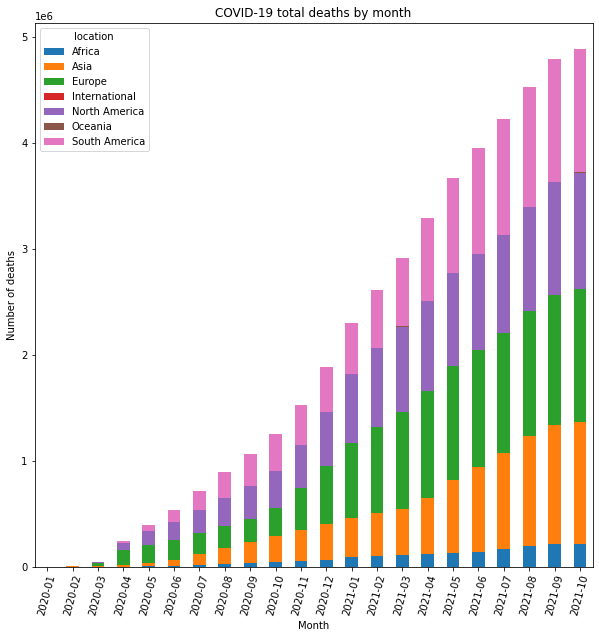

In [32]:
continents_deaths_monthly.plot.bar(stacked=True, rot=75, title="COVID-19 total deaths by month")
plt.xlabel('Month')
plt.ylabel('Number of deaths')
plt.show(block=True)

# A closer look at select countries

Earlier on in the project, we calculated some percentages for our entire dataset.
* percent_infected
* percent_dead
* percent_vaccinated

To illustrate the events related to the COVID-19 pandemic, let's visualize some of that data. First, we'll identify a group of countries to follow.

In [33]:
nations_to_follow = ['United States', 'Italy', 'China', 'New Zealand', 'Peru', 'India', 'Iran', 'United Kingdom', 'Switzerland']
select_data = covid_select.loc[covid_select['location'].isin(nations_to_follow)]

In [34]:
# Drop columns not needed
select_data = select_data[['date', 'location', 'percent_infected', 'percent_dead', 'percent_vaxed']]

In [35]:
# Color scheme for line graphs below
colors = [
    "#F94144", 
    "#F3722C", 
    "#F8961E", 
    "#F9C74F", 
    "#90BE6D",
    "#43AA8B",
    "#4D908E",
    "#577590",
    "#277DA1"
]

## Percent Infected
Now, let's take a look at the `percent_infected` data for these countries.

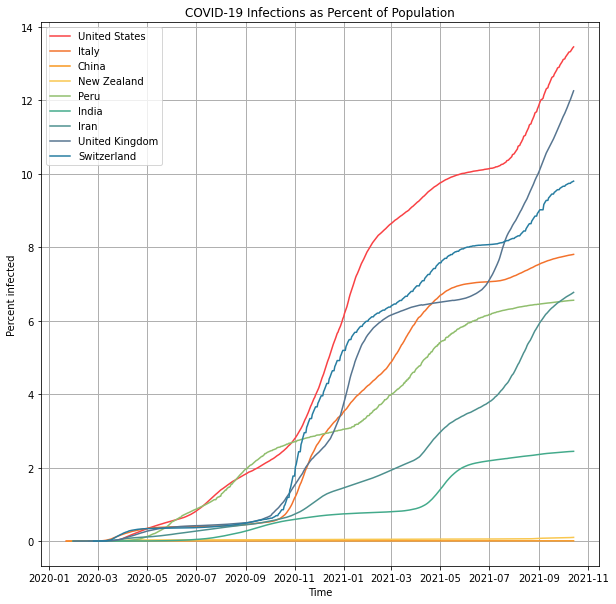

In [36]:
for (n, c) in zip(nations_to_follow, colors):
    selected_rows = select_data[select_data['location'] == n]
    plt.plot(selected_rows.loc[:,"date"], selected_rows.loc[:,"percent_infected"], color=c, label=n)

plt.title("COVID-19 Infections as Percent of Population")
plt.xlabel("Time")
plt.ylabel("Percent infected")
plt.grid(linewidth=1)
plt.legend()
plt.show()

## Percent of infected that died

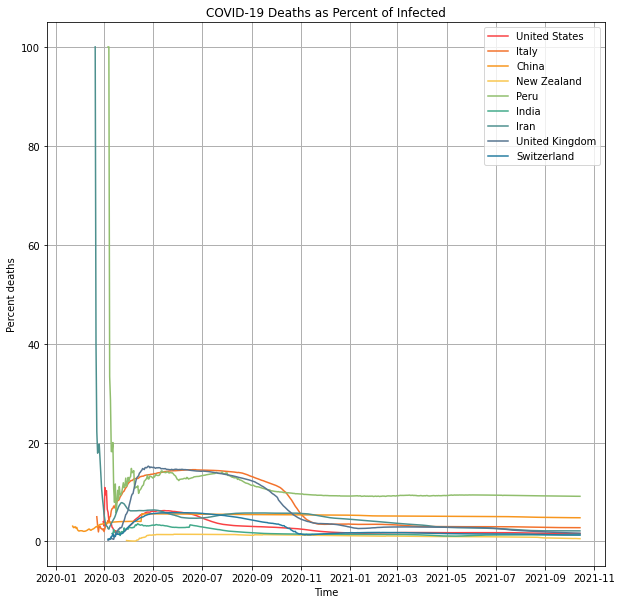

In [37]:
for (n, c) in zip(nations_to_follow, colors):
    selected_rows = select_data[select_data['location'] == n]
    plt.plot(selected_rows.loc[:,"date"], selected_rows.loc[:,"percent_dead"], color=c, label=n)

plt.title("COVID-19 Deaths as Percent of Infected")
plt.xlabel("Time")
plt.ylabel("Percent deaths")
plt.grid(linewidth=1)
plt.legend()
plt.show()

## Percent of population to receive vaccine

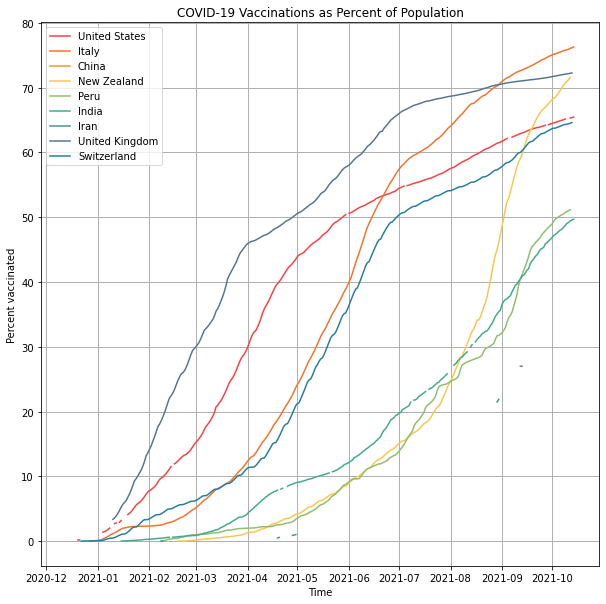

In [38]:
for (n, c) in zip(nations_to_follow, colors):
    selected_rows = select_data[select_data['location'] == n]
    plt.plot(selected_rows.loc[:,"date"], selected_rows.loc[:,"percent_vaxed"], color=c, label=n)


plt.title("COVID-19 Vaccinations as Percent of Population")
plt.xlabel("Time")
plt.ylabel("Percent vaccinated")
plt.grid(linewidth=1)
plt.legend()
plt.show()

## New cases, deaths, vaccinations
Previously, we were looking at the total cases, deaths, and vaccinations for a group of countries. We will now look at the new cases, deaths, and vaccinations for the same countries and display it using a circle chart in altair. To help make the chart more readable, we will use monthly values instead of daily.

In [39]:
# Prepare new dataframe for monthly data
monthly_data = pd.DataFrame(columns = ['country', 'new_cases', 'new_deaths', 'new_vaxes', 'month_year'])

In [40]:
months = list(pd.date_range(start='1/1/2020', end='10/1/2021', freq='MS').strftime("%Y-%m"))

In [41]:
#nations_to_follow = ['United States', 'Italy', 'China', 'New Zealand', 'Peru', 'India', 'Iran', 'United Kingdom', 'Switzerland']
for n in nations_to_follow: 

    for m in months:
        selected_rows = covid_countries[(covid_countries['location'] == n) & 
                                         (covid_countries['month_year'] == m)]        
        # Calculations
        cases = selected_rows['new_cases'].sum()
        deaths = selected_rows['new_deaths'].sum()
        vaxes = selected_rows['new_vaccinations'].sum()

        # Add to dataframe
        monthly_data = monthly_data.append({'country' : n, 'new_cases' : cases, 'new_deaths' : deaths, 'new_vaxes' : vaxes, 'month_year' : m }, ignore_index=True)

In [42]:
monthly_data

,country,new_cases,new_deaths,new_vaxes,month_year
0,United States,7.0,0.0,0.0,2020-01
1,United States,17.0,1.0,0.0,2020-02
2,United States,192054.0,5361.0,0.0,2020-03
3,United States,888863.0,60825.0,0.0,2020-04
4,United States,718732.0,41546.0,0.0,2020-05
...,...,...,...,...,...
193,Switzerland,8264.0,61.0,2536414.0,2021-06
194,Switzerland,14661.0,20.0,1465053.0,2021-07
195,Switzerland,62001.0,106.0,620681.0,2021-08
196,Switzerland,60697.0,188.0,821517.0,2021-09


In [43]:
alt.data_transformers.disable_max_rows()

alt.Chart(monthly_data).mark_circle().encode(
    x='month_year', #'monthdate(month_year):O'
    y='country',
    color='country',
    size=alt.Size(
        'new_cases:Q',
        scale=alt.Scale(range=[0,900]),
        legend=alt.Legend(title='Daily new cases')
    )
).properties(
    width=500,
    height=300,
    title='New cases of COVID-19'
)

alt.Chart(...)

# COVID-19 data for the United States

Now that we've got a global picture, let's visualize the data we have for the United States using the altair library for Python. These charts will be interactive.

In [44]:
# Create new dataframe for USA rows
usa = covid_select[covid_select['location'] == "United States"]
usa = usa[['date', 'new_cases', 'new_vaccinations', 'new_deaths', 'total_cases', 'total_vaccinations', 'total_deaths']]
usa.tail(3)

,date,new_cases,new_vaccinations,new_deaths,total_cases,total_vaccinations,total_deaths
117913,2021-10-12,106308.0,NaN,2416.0,44562693.0,403576826.0,716471.0
117914,2021-10-13,121457.0,794421.0,3087.0,44684150.0,404371247.0,719558.0
117915,2021-10-14,83756.0,1073311.0,2005.0,44767906.0,405444558.0,721563.0


In order to display the USA data in a circle chart using the `altair` library, we need the data in a slightly different form. For each day that we have data, there will need to be a separate row for each kind of data that we want to display. 

On the first graph, we'll plot:
* `new_cases`
* `new_deaths` 
* `new_vaccinations`

On the second graph:
* `total_cases`
* `total_deaths`
* `total_vaccinations`

In [45]:
# Create two empty dataframes
usa_new = pd.DataFrame(columns = ['date', 'type', 'count'])
usa_total = pd.DataFrame(columns = ['date', 'type', 'count'])

In [46]:
# Process our USA dataframe row by row and append it to our new dataframes
def get_usa_data(usa):
    global usa_new, usa_total
    
    for i in usa.index:
        # get data from original df
        d = usa['date'][i]
        n_cases = usa['new_cases'][i]
        n_vaxes = usa['new_vaccinations'][i]
        n_deaths = usa['new_deaths'][i]
        t_cases = usa['total_cases'][i]
        t_vaxes = usa['total_vaccinations'][i]
        t_deaths = usa['total_deaths'][i]

        # add data to df in six rows
        usa_new = usa_new.append({'date' : d, 'type' : 'new_cases', 'count' : n_cases }, ignore_index=True)
        usa_new = usa_new.append({'date' : d, 'type' : 'new_deaths', 'count' : n_deaths }, ignore_index=True)
        usa_new = usa_new.append({'date' : d, 'type' : 'new_vaccinations', 'count' : n_vaxes }, ignore_index=True)
        usa_total = usa_total.append({'date' : d, 'type' : 'total_cases', 'count' : t_cases }, ignore_index=True)
        usa_total = usa_total.append({'date' : d, 'type' : 'total_deaths', 'count' : t_deaths }, ignore_index=True)
        usa_total = usa_total.append({'date' : d, 'type' : 'total_vaccinations', 'count' : t_vaxes }, ignore_index=True)
        
get_usa_data(usa)

Now we have our data structured correctly for display as a circle chart.

In [47]:
# Verify contents of dataframe
usa_new

,date,type,count
0,2020-01-22,new_cases,NaN
1,2020-01-22,new_deaths,NaN
2,2020-01-22,new_vaccinations,NaN
3,2020-01-23,new_cases,0.0
4,2020-01-23,new_deaths,NaN
...,...,...,...
1891,2021-10-13,new_deaths,3087.0
1892,2021-10-13,new_vaccinations,794421.0
1893,2021-10-14,new_cases,83756.0
1894,2021-10-14,new_deaths,2005.0


In [48]:
# Setting colors for chart: cases = yellow, deaths = red, vaxes = green
scale = alt.Scale(domain=['new_cases', 'new_deaths', 'new_vaccinations'],
                  range=['#ffcc00', '#cc3300', '#99cc33'])

In [49]:
alt.Chart(usa_new).mark_circle(size=50).encode(
    alt.X('date:T', title='date'),
    alt.Y('count:Q', title='count'),
    alt.Color('type', scale=scale, title='Type of data'),
    alt.Tooltip('date:T')
).properties(
    width=500,
    height=300,
    title='USA & COVID-19: New cases, deaths, vaccinations'
).interactive()

alt.Chart(...)

In the interactive chart above, the most dramatic feature is the extremely large number of vaccinations taking place around March and April of 2021. Feel free to zoom in for a closer look at this interactive chart.

Now, let's plot our second interactive graph.

In [50]:
# Verify contents of dataframe
usa_total

,date,type,count
0,2020-01-22,total_cases,1.0
1,2020-01-22,total_deaths,NaN
2,2020-01-22,total_vaccinations,NaN
3,2020-01-23,total_cases,1.0
4,2020-01-23,total_deaths,NaN
...,...,...,...
1891,2021-10-13,total_deaths,719558.0
1892,2021-10-13,total_vaccinations,404371247.0
1893,2021-10-14,total_cases,44767906.0
1894,2021-10-14,total_deaths,721563.0


In [51]:
# Setting colors for chart: cases = yellow, deaths = red, vaxes = green
scale = alt.Scale(domain=['total_cases', 'total_deaths', 'total_vaccinations'],
                  range=['#ffcc00', '#cc3300', '#99cc33'])

In [52]:
alt.Chart(usa_total).mark_circle(size=20).encode(
    alt.X('date:T', title='date'),
    alt.Y('count:Q', title='count'),
    alt.Color('type', scale=scale, title='Type of data'),
    alt.Tooltip('date:T')
).properties(
    width=500,
    height=300,
    title='USA & COVID-19: Total cases, deaths, vaccinations'
).interactive()

alt.Chart(...)

# Summary

In this project, we explored and visualized a large set of COVID-19 data with daily values for every country in the world. 
* We identified the countries with the highest infection rates around the world and displayed it using a matplotlib bar chart. 
* Using the Pandas groupby function, we were able to determine infections by continent over time and display it in a matplotlib stacked bar chart. We did the same for deaths by continent over time.
* For a select group of countries, we visualized the percent infected, dead, and vaccinated data over time using multiple line graphs in matplotlib.
* For the same countries, we also visualized new cases as a time series using an Altair circle chart.
* Finally, we examined United States COVID-19 data over time through interactive Altair scatter plots with tooltips. 